In [1]:
%%capture
import pickle as pkl
import rpy2
import xarray
import pandas as pd
import numpy as np
import scipy as sp
import scipy.stats as st
import seaborn as sns
from matplotlib import pyplot as plt
from poisson import poisson_similarity
from plot import plot_poisson_ordered, plot_distplots
from util import get_amelie_selection
from os.path import join
from rpy2.robjects import pandas2ri
from os.path import join
import rpy2.robjects as robjects
pandas2ri.activate()
%load_ext rpy2.ipython
%R require(PhenotypeImputation)
%R require(mice)

In [2]:
%%R -o root
config <- config::get()
root = config$root

In [3]:
root = root[0]
print("Folder containing the data dataset: {}".format(root))

Folder containing the data dataset: /ipfs/QmbBGQnqoEjxBuoq5eruMdExNxbruYkKMkNR9NwDuyKdGT


# 1.1 Original measurements

In [4]:
## from figshare ####
measures = pd.read_csv(join(root, "rawdata/figshare/measures.txt"), sep="\t")
measures = measures.rename(columns={"SUBJECT.NAME": "subject"})
measures = measures.set_index("subject")
measures.head()

FileNotFoundError: File b'/ipfs/QmbBGQnqoEjxBuoq5eruMdExNxbruYkKMkNR9NwDuyKdGT/rawdata/figshare/measures.txt' does not exist

In [5]:
%%capture
%%R -o pheno_ScientificData -o pheno_NatGenet
directory <- paste(config$root, "rawdata", sep="/")

## from figshare ####
measures <- data.table::fread(paste(directory, "/figshare/measures.txt", sep=""),
                  data.table=FALSE, stringsAsFactors = FALSE)

## from Baud et al (2014) ####
pheno_ScientificData <- data.table::fread(paste(directory,
                                 "/PublicationResults/ScientificDataS1.csv",
                                 sep=""),
                     data.table=FALSE, stringsAsFactors = FALSE,
                     skip=2)[, -c(6:7)]
colnames(pheno_ScientificData) <- gsub(" ", "", colnames(pheno_ScientificData))
pheno_ScientificData$gsub <- gsub("_normalized_by_batch", "",
                                  pheno_ScientificData$Measure)

## from Baud et al (2013) ####
pheno_NatGenet <- data.table::fread(paste(directory,
                              "/PublicationResults/",
                              "SupplementaryTable1_Phenotypes.csv", sep=""),
                              data.table=FALSE, stringsAsFactors = FALSE,
                        skip=3)
colnames(pheno_NatGenet) <- gsub(" ", "", colnames(pheno_NatGenet))
pheno_NatGenet$MeasureinGSCAN <- gsub("_bc", "", pheno_NatGenet$MeasureinGSCAN)

# 1.2 From Baud et al (2014)

In [6]:
pheno_ScientificData.head()

,Phenotypingtest,Measure,Description,Numberofobservations,Unit,gsub
0,Arterial elastic lamina ruptures,AA_IL_nb,Number of lesions in AA and IL,1005,,AA_IL_nb
1,Arterial elastic lamina ruptures,AA_IL_score,Score of lesions in AA and IL,1005,,AA_IL_score
2,Arterial elastic lamina ruptures,AA_nb,Number of lesions in AA,1005,,AA_nb
3,Arterial elastic lamina ruptures,AA_score,Score of lesions in AA,1005,,AA_score
4,Arterial elastic lamina ruptures,IL_nb,Number of lesions in IL,1005,,IL_nb


# 1.3 From Baud et al (2013)

In [7]:
pheno_NatGenet.head()

,Phenotype,Measure,MeasureinGSCAN,Covariates,Transformation,Mappingmethod,Threshold,Noanimals
0,Anxiety (novel cage),Distance 25' to 30',Distance25_30,"sex,batch,is.albino",boxcox,Mixed models,4.2,1369
1,Anxiety (novel cage),Distance first 5',Distance5,"sex,batch,is.albino",boxcox,Mixed models,4.1,1367
2,Anxiety (shuttlebox),Mean response latency,Latency1_40,"sex,batch,is.albino",boxcox,Mixed models,4.1,1366
3,Anxiety (shuttlebox),Number of avoidances,Avoidances1_40,"sex,batch,is.albino",,Resampling,0.4,1369
4,Anxiety (shuttlebox),Number of crosses between trials,InterTrialCross1_40,"sex,batch,is.albino",,Resampling,0.3,1369


In [8]:
pheno_normal = join(root, "processeddata/phenotypes_normal.csv")
pheno_notNormal = join(root, "processeddata/phenotypes_notNormal.csv")
pheno_normal = pd.read_csv(pheno_normal)
pheno_notNormal = pd.read_csv(pheno_notNormal)
pheno_normal = pheno_normal.rename(columns={"Unnamed: 0": "subject"})
pheno_notNormal = pheno_notNormal.rename(columns={"Unnamed: 0": "subject"})
pheno_normal = pheno_normal.set_index("subject")
pheno_notNormal = pheno_notNormal.set_index("subject")

In [9]:
pheno_cols = np.concatenate([pheno_normal.columns.values, pheno_notNormal.columns.values])
not_pheno_cols = list(set(measures.columns.values) - set(pheno_cols))
measures_notin_pheno = measures[not_pheno_cols].copy()

# 1.4 Traits that were not found in Hannah's analysis

In [10]:
measures_notin_pheno.head()

,Rearing0_30,Avoidances31_40,abs_neuts,BW_week17,Latency6_10,Rearing5,died_of_EAE,Latency11_20,EAE_score_at_sacrifice,cage,...,Latency1_20,Distance5_10,reliable_ear_hole,LineCrossings,blood_pressure_time,BW_week9,date_IPGTT,Rearing25,InterTrialCross1_10,Hole.area
subject,,,,,,,,,,,,,,,,,,,,,
Outbred1,23.0,0.0,2.73,348.0,18.52,17.0,False,11.19,0.0,1AF,...,15.69,244.0,True,9.0,9.0,NaN,08/10/2007,6.0,3.0,2.432
Outbred10,79.0,6.0,1.36,334.0,12.60,15.0,False,12.42,0.0,1AJ,...,13.01,1246.0,True,14.0,10.0,NaN,08/10/2007,64.0,3.0,3.988
Outbred100,38.0,0.0,0.44,286.0,19.26,2.0,False,24.46,NaN,1CE,...,20.99,882.0,True,17.0,12.0,NaN,15/10/2007,36.0,3.0,0.946
Outbred1000,85.0,2.0,1.46,329.0,12.58,12.0,False,11.81,0.0,5E,...,12.04,2380.0,True,53.0,9.0,167.0,11/02/2009,73.0,2.0,3.700
Outbred1001,86.0,0.0,0.96,331.0,15.22,21.0,False,16.60,0.0,5E,...,15.58,2155.0,False,40.0,9.0,244.0,11/02/2009,65.0,5.0,4.409


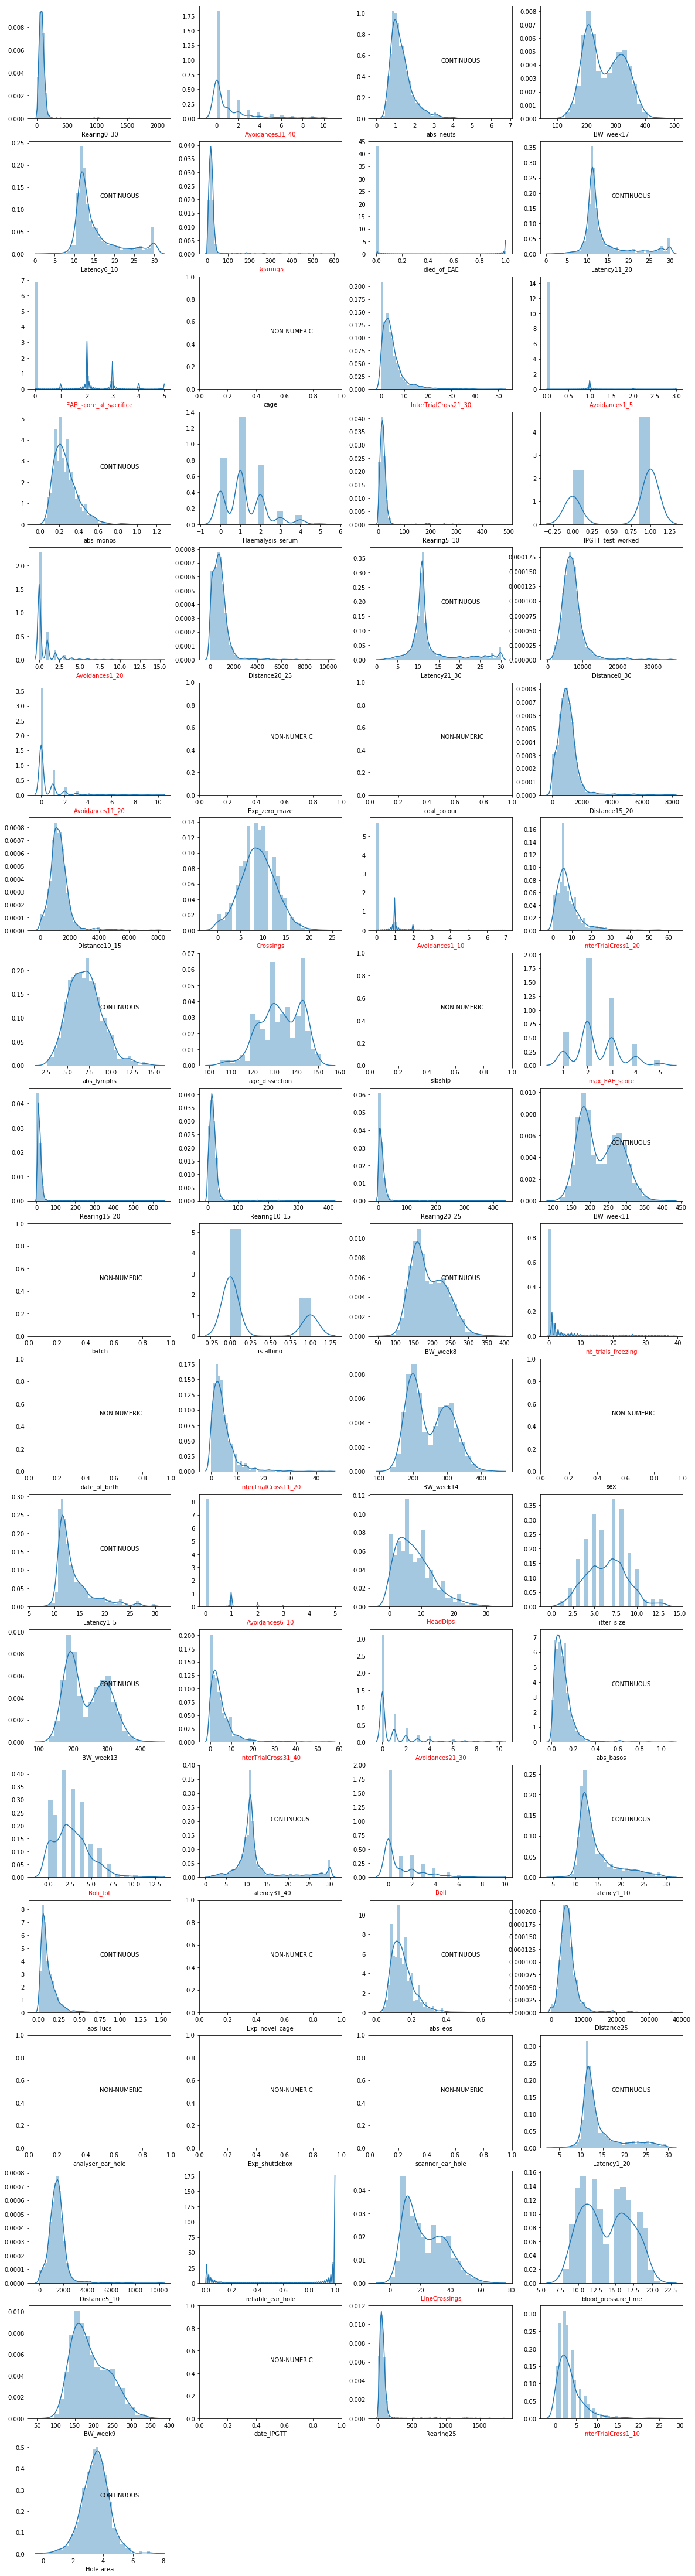

In [11]:
plot_distplots(measures_notin_pheno, 80)

# 1.5 Traits that are considered normal in Hannah's analysis

In [12]:
pheno_normal.head()

,Distance25_30,Distance5,ALP,ALT,AST,Calcium,Chloride,Creatinine,Glucose,HDL,...,G0,G120,G30,G60,Latency1_40,time_freezing,LatencyOpenSection,PosturesClosedToOpen,TimeOpenSection,PltClumps
subject,,,,,,,,,,,,,,,,,,,,,
Outbred1,410.0,1529.0,159.0,61.7,123.8,2.51,97.0,30.1,12.92,1.11,...,6.2,5.9,7.8,6.8,14.18,297.0,NaN,7.0,NaN,89.0
Outbred10,756.0,1356.0,128.0,59.6,112.6,2.27,91.0,27.7,9.89,0.91,...,5.8,5.8,8.7,6.7,10.62,NaN,68.0,8.0,19.0,81.0
Outbred100,523.0,789.0,205.0,87.3,133.5,2.58,101.0,29.1,12.24,1.27,...,6.4,5.9,10.4,7.4,17.18,NaN,8.0,11.0,135.0,247.0
Outbred1000,2147.0,2801.0,269.0,53.8,126.7,2.65,102.0,31.9,8.58,1.16,...,5.3,5.4,7.2,6.0,11.24,273.0,14.0,9.0,143.0,49.0
Outbred1001,2359.0,3056.0,201.0,69.5,145.8,2.62,101.0,36.4,8.80,1.20,...,4.7,4.7,7.7,5.6,13.97,NaN,24.0,6.0,100.0,44.0


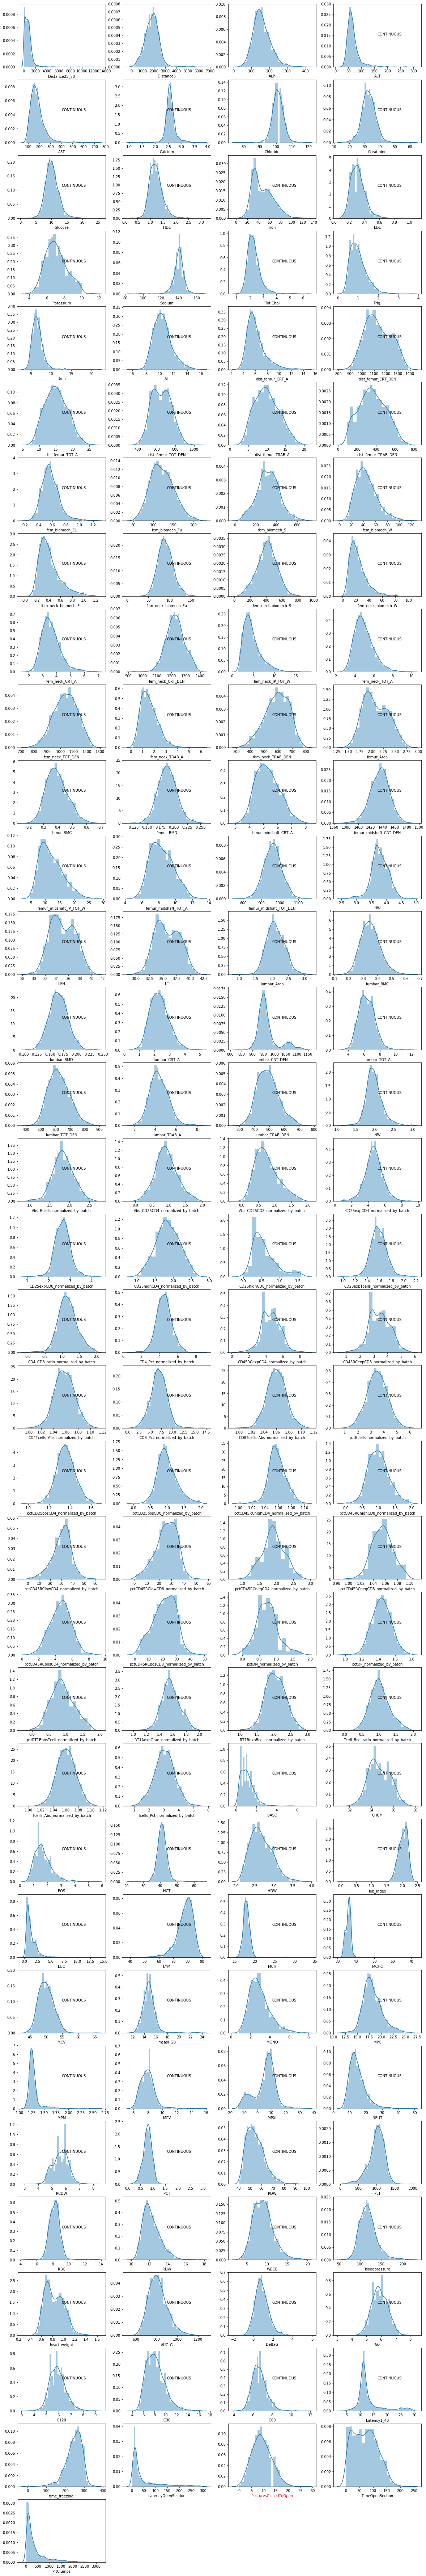

In [13]:
plot_distplots(pheno_normal, 130)

# 1.6 Traits that are NOT considered normal in Hannah's analysis

In [14]:
pheno_notNormal.head()

,Has1kidney,AA_IL_nb,AA_IL_score,AA_nb,AA_score,IL_nb,IL_score,Avoidances1_40,InterTrialCross1_40,EntriesOpenSection
subject,,,,,,,,,,
Outbred1,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,7.0,0.0
Outbred10,0,NaN,NaN,NaN,NaN,NaN,NaN,9.0,14.0,3.0
Outbred100,1,NaN,NaN,NaN,NaN,NaN,NaN,0.0,5.0,3.0
Outbred1000,0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,15.0,15.0
Outbred1001,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.0,10.0


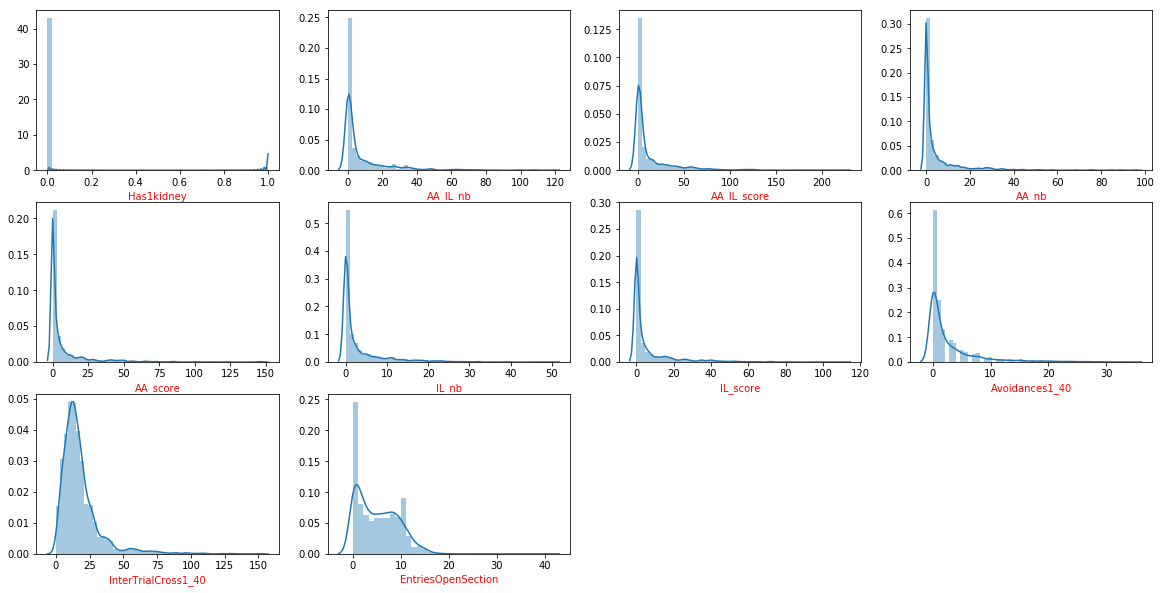

In [15]:
plot_distplots(pheno_notNormal, 10)

# 1.7 Covariates 

In [16]:
%%R
covariate_names <- dplyr::filter(pheno_ScientificData, Phenotypingtest == "Covariate")

phenotype_names <- dplyr::filter(pheno_ScientificData, Phenotypingtest != "Covariate")

phenotype_names <- merge(phenotype_names, pheno_NatGenet[, -c(1:2,8)],
                         by.x="gsub", by.y="MeasureinGSCAN", all=TRUE)

phenotype_names_notN <- dplyr::filter(phenotype_names, Mappingmethod != "Mixed models",
                   !is.na(Measure))

phenotype_names_N <- dplyr::filter(phenotype_names,
                    Mappingmethod == "Mixed models", !is.na(Measure))

phenotypes_normal <- measures[, colnames(measures) %in% phenotype_names_N$Measure ]

rownames(phenotypes_normal) <- measures$SUBJECT.NAME

phenotypes_notNormal <- measures[, colnames(measures) %in% phenotype_names_notN$Measure ]

rownames(phenotypes_notNormal) <- measures$SUBJECT.NAME

In [17]:
%%R -o covariates

covariates <- measures[, colnames(measures) %in%
                           c("BW_week11", "BW_week14", "BW_week17",
                              covariate_names$Measure) ]
covariates <- apply(covariates, 2, function(x) {
    if (! is.numeric(x)) return(as.numeric(as.factor(x)))
    if (is.numeric(x)) return(x)
})
rownames(covariates) <- measures$SUBJECT.NAME

# manually match covariate names from NatGenetc supp info to colnames of measure/
# covariates
#colnames(covariates)
#[1] "BW_week11"   "age_dissection"  "analyser_ear_hole"  "batch"
#[5] "blood_pressure_time"   "cage"  "date_IPGTT"   "date_of_birth"
#[9] "died_of_EAE"   "sibship"   "Haemalysis_serum"   "is.albino"
#[13] "litter_size"   "max_EAE_score"   "reliable_ear_hole"   "scanner_ear_hole"
#[17] "EAE_score_at_sacrifice" "sex"   "IPGTT_test_worked"   "BW_week14"
#[21] "BW_week17"   "Exp_novel_cage"   "Exp_zero_maze" "Exp_shuttlebox"

## information about conversion of these variables directly from from Amelie Baud
colnames(covariates)[colnames(covariates) == "BW_week11"] <- "BW_at_IPGTT"
colnames(covariates)[colnames(covariates) == "BW_week14"] <- "BW_at_day9_pi"
colnames(covariates)[colnames(covariates) == "BW_week17"] <- "BW_at_day28_pi"
colnames(covariates)[colnames(covariates) == "age_dissection"] <- "age"
colnames(covariates)[colnames(covariates) == "Haemalysis_serum"] <- "Haemalysis"
colnames(covariates)[colnames(covariates) == "IPGTT_test_worked"] <- "test_worked"

In [18]:
measure_renaming = dict()
measure_renaming["BW_week11"] = "BW_at_IPGTT"
measure_renaming["BW_week14"] = "BW_at_day9_pi"
measure_renaming["BW_week17"] = "BW_at_day28_pi"
measure_renaming["age_dissection"] = "age"
measure_renaming["Haemalysis_serum"] = "Haemalysis"
measure_renaming["IPGTT_test_worked"] = "test_worked"
measure_renaming.update({v: k for (k, v) in measure_renaming.items()})

# 1.8 Map covariates to phenotypes

In [19]:
%%R -o uniqueCovariatesTested -o relevantCovariates

root = config$root
directory <- paste(config$root, "processeddata", sep="/")

phenotype_names_N <- phenotype_names_N[phenotype_names_N$Measure %in%
                                       colnames(phenotypes_normal),]
phenotype_names_N <- phenotype_names_N[ match(colnames(phenotypes_normal),
                                       phenotype_names_N$Measure),]

phenotype2covs <- lapply(1:nrow(phenotype_names_N), function(x) {
    unlist(strsplit(phenotype_names_N$Covariates[x], ","))
})
names(phenotype2covs) <- phenotype_names_N$Measure
# saveRDS(phenotype2covs, paste(directory, "/phenotype2covs.rds", sep=""))

uniqueCovariatesTested <- unique(unlist(phenotype2covs))
#[1] "sex" "batch" "is.albino" "Haemalysis"
#[5] "BW_at_day28_pi" "BW_at_day9_pi" "age" "BW_at_IPGTT" "test_worked"
relevantCovariates <- covariates[,colnames(covariates) %in% uniqueCovariatesTested]
# write.table(relevantCovariates, paste(directory, "/covariates.csv", sep=""),
#             row.names=TRUE, col.names=NA, quote=FALSE, sep=",")

In [20]:
%%R -o phenotype2covs

phenotype2covs <- readRDS(paste(directory, "/phenotype2covs.rds", sep=""))

In [21]:
relevantCovariates = pd.read_csv(join(root, "processeddata", "covariates.csv"))
relevantCovariates = relevantCovariates.rename(columns={"Unnamed: 0": "subject"})
relevantCovariates = relevantCovariates.set_index("subject")
relevantCovariates.head()

,BW_at_IPGTT,age,batch,Haemalysis,is.albino,sex,test_worked,BW_at_day9_pi,BW_at_day28_pi
subject,,,,,,,,,
Outbred1,428.0,NaN,1,1.0,2,2,1,172.0,212.0
Outbred10,442.0,NaN,1,3.0,2,2,1,176.0,198.0
Outbred100,396.0,NaN,1,3.0,2,2,1,169.0,150.0
Outbred1000,415.0,14.0,5,1.0,2,2,1,159.0,193.0
Outbred1001,465.0,14.0,5,1.0,2,2,1,171.0,195.0


In [22]:
def rds2dict(x):
    y = dict()
    for i in range(len(x)):
        y[x.names[i]] = list(x[i])
    return y
phenotype2covs = rds2dict(phenotype2covs)

In [23]:
for v in relevantCovariates.columns.values:
    if v in list(measures.columns.values):
        print("{} covariate found in `measures`".format(v))
    else:
        if measure_renaming[v] in list(measures.columns.values):
            print("{} covariate found in `measures` after RENAMING".format(v))
        else:
            print("{} covariate NOT found in `measures`".format(v))

BW_at_IPGTT covariate found in `measures` after RENAMING
age covariate found in `measures` after RENAMING
batch covariate found in `measures`
Haemalysis covariate found in `measures` after RENAMING
is.albino covariate found in `measures`
sex covariate found in `measures`
test_worked covariate found in `measures` after RENAMING
BW_at_day9_pi covariate found in `measures` after RENAMING
BW_at_day28_pi covariate found in `measures` after RENAMING


In [24]:
for v in list(covariates.colnames):
    if v in list(measures.columns.values):
        print("{} covariate found in `measures`".format(v))
    else:
        if measure_renaming[v] in list(measures.columns.values):
            print("{} covariate found in `measures` after RENAMING".format(v))
        else:
            print("{} covariate NOT found in `measures`".format(v))

BW_at_IPGTT covariate found in `measures` after RENAMING
age covariate found in `measures` after RENAMING
analyser_ear_hole covariate found in `measures`
batch covariate found in `measures`
blood_pressure_time covariate found in `measures`
cage covariate found in `measures`
date_IPGTT covariate found in `measures`
date_of_birth covariate found in `measures`
died_of_EAE covariate found in `measures`
sibship covariate found in `measures`
Haemalysis covariate found in `measures` after RENAMING
is.albino covariate found in `measures`
litter_size covariate found in `measures`
max_EAE_score covariate found in `measures`
reliable_ear_hole covariate found in `measures`
scanner_ear_hole covariate found in `measures`
EAE_score_at_sacrifice covariate found in `measures`
sex covariate found in `measures`
test_worked covariate found in `measures` after RENAMING
BW_at_day9_pi covariate found in `measures` after RENAMING
BW_at_day28_pi covariate found in `measures` after RENAMING
Exp_novel_cage covar

In [25]:
covariates0 = covariates
covariates = pd.DataFrame(np.asarray(covariates0))
covariates.columns = list(covariates0.colnames)
covariates["subject"] = list(covariates0.rownames)
covariates = covariates.set_index("subject")

# 1.9 Kinship

In [26]:
%%capture
%%R -o kinship -o common_samples

## directories ####
rawdir <- paste(root, "/rawdata/arrayexpress", sep="")
directory <- paste(root, "/processeddata", sep="")

## data ####
phenotypes_normal <- read.table(paste(directory, "/phenotypes_normal.csv",
                                      sep=""),
                            header=TRUE, row.names=1, stringsAsFactors=FALSE,
                            sep=",")

covariates <- read.table(paste(directory, "/covariates.csv", sep=""),
                         header=TRUE, row.names=1, stringsAsFactors=FALSE,
                         sep=",")

kinship <- read.table(paste(rawdir, "/HS_rats_kinship_norm.csv", sep=""),
                      header=TRUE, stringsAsFactors=FALSE,
                      sep=",")
                      
common_samples <- colnames(kinship)[colnames(kinship) %in% rownames(phenotypes_normal)]

kinship <- kinship[colnames(kinship) %in% common_samples, colnames(kinship) %in% common_samples]

phenotypes_normal <- phenotypes_normal[rownames(phenotypes_normal) %in% common_samples,]
phenotypes_normal <- phenotypes_normal[match(colnames(kinship), rownames(phenotypes_normal)),]

covariates <- covariates[rownames(covariates) %in% common_samples,]
covariates <- covariates[match(colnames(kinship), rownames(covariates)),]

# for imputation purposes, combine covariate and phenotype data
combined_all <- cbind(covariates, phenotypes_normal)

## general parameters ####
cutoff <- 0.95
col <- c('#fc8d62','#8da0cb')
text_size <- 12

In [27]:
kinship.index = kinship.columns.values.copy()
kinship.head()

,Outbred10,Outbred100,Outbred1000,Outbred1001,Outbred1002,Outbred1003,Outbred1006,Outbred1007,Outbred1008,Outbred1009,...,Outbred987,Outbred988,Outbred989,Outbred990,Outbred991,Outbred992,Outbred993,Outbred994,Outbred995,Outbred999
Outbred10,6.009824,4.657918,5.479625,5.418838,5.404296,5.439283,5.226009,5.008503,4.948340,4.981719,...,4.980516,4.963946,4.894734,4.914590,4.949563,4.680058,4.830228,4.834785,4.789685,5.383430
Outbred100,4.657918,5.737956,4.764362,4.701020,4.709254,4.748388,4.813588,4.911552,4.841216,4.883429,...,4.865227,4.862593,4.794374,4.816218,4.885404,4.630496,4.834140,4.868218,4.862943,4.754280
Outbred1000,5.479625,4.764362,6.200240,5.806138,5.747500,5.778229,5.349606,5.087776,5.012144,5.071292,...,5.021771,5.056555,4.964942,4.964675,5.057984,4.802489,4.999009,5.008811,4.949830,5.867601
Outbred1001,5.418838,4.701020,5.806138,6.125864,5.861705,5.813432,5.328939,5.073914,4.984344,5.050553,...,4.973953,4.967413,4.921145,4.901156,4.981035,4.752995,4.962390,4.960466,4.915544,5.767700
Outbred1002,5.404296,4.709254,5.747500,5.861705,6.186393,5.757447,5.352778,5.080052,5.012185,5.100002,...,4.944851,4.981080,4.901690,4.904372,4.987777,4.702598,4.895629,4.898984,4.862922,5.820061


In [28]:
K = xarray.DataArray(kinship.copy()).rename({"dim_0": "subject_0", "dim_1": "subject_1"})

# 1.19 Imputed traits

In [29]:
folder = join(root, "processeddata")
ipheno = join(folder, "imputed_phenotypes.rds")
readRDS = robjects.r["readRDS"]
df = readRDS(ipheno)
# $imp$phenix$imp
m = pandas2ri.ri2py(df[0][0][0])
ipheno = pd.DataFrame(
    data=m, columns=list(df[0][0][0].colnames), index=list(df[0][0][0].rownames)
)
ipheno.head()

,BW_at_IPGTT,age,batch,Haemalysis,is.albino,sex,test_worked,BW_at_day9_pi,BW_at_day28_pi,Distance25_30,...,heart_weight,AUC_G,DeltaG,G0,G120,G30,G60,Latency1_40,PosturesClosedToOpen,PltClumps
Outbred1000,415.0,14.0,5.0,1.0,2.0,2.0,1.0,159.0,193.0,2147.0,...,1.0740,727.5,0.7625,5.3,5.4,7.2,6.0,11.24,9.0,49.0
Outbred1001,465.0,14.0,5.0,1.0,2.0,2.0,1.0,171.0,195.0,2359.0,...,1.0217,694.5,1.0875,4.7,4.7,7.7,5.6,13.97,6.0,44.0
Outbred1002,415.0,14.0,5.0,1.0,2.0,2.0,1.0,160.0,180.0,896.0,...,0.9952,811.5,1.3625,5.4,6.8,8.7,5.9,12.42,5.0,44.0
Outbred1003,376.0,14.0,5.0,1.0,2.0,2.0,1.0,155.0,181.0,910.0,...,0.9653,726.0,0.6500,5.4,5.0,8.1,5.6,11.25,4.0,55.0
Outbred1006,257.0,17.0,5.0,1.0,1.0,2.0,2.0,96.0,119.0,727.0,...,0.9420,802.5,0.8875,5.8,6.9,7.2,6.5,11.23,6.0,110.0


In [30]:
common_samples = list(common_samples)

In [31]:
print("measures:             {}  # collection of all measurements".format(measures.shape))
print("phenotype2covs:       {}          # mapping from trait to covariates".format(len(phenotype2covs)))
print("pheno_NatGenet:       {}     # metainfo about traits from Baud et al (2013)".format(pheno_NatGenet.shape))
print("pheno_ScientificData: {}     # metainfo about traits from Baud et al (2014)".format(pheno_ScientificData.shape))
print("pheno_normal:         {}  # normal traits from Hannah".format(pheno_normal.shape))
print("pheno_notNormal:      {}   # notNormal traits from Hannah".format(pheno_notNormal.shape))
print("measures_notin_pheno:       {}   # measurements not found in pheno_cols".format(measures_notin_pheno.shape))
print("covariates:           {}   # covariates from Hannah".format(covariates.shape))
print("relevantCovariates:   {}    # relevant covariates from Hannah".format(relevantCovariates.shape))
print("measure_renaming:     {}           # bidirectional mapping of Hannah's measurement renaming".format(len(measure_renaming)))
print("kinship:              {} # kinship".format(kinship.shape))
print("common_samples        {}         # common samples between traits data and kinship".format(len(common_samples)))
print("ipheno:               {}  # imputed traits from Hannah".format(ipheno.shape))

measures:             (2006, 216)  # collection of all measurements
phenotype2covs:       133          # mapping from trait to covariates
pheno_NatGenet:       (160, 8)     # metainfo about traits from Baud et al (2013)
pheno_ScientificData: (216, 6)     # metainfo about traits from Baud et al (2014)
pheno_normal:         (2006, 133)  # normal traits from Hannah
pheno_notNormal:      (2006, 10)   # notNormal traits from Hannah
measures_notin_pheno:       (2006, 73)   # measurements not found in pheno_cols
covariates:           (2006, 24)   # covariates from Hannah
relevantCovariates:   (2006, 9)    # relevant covariates from Hannah
measure_renaming:     12           # bidirectional mapping of Hannah's measurement renaming
kinship:              (1407, 1407) # kinship
common_samples        1407         # common samples between traits data and kinship
ipheno:               (1096, 107)  # imputed traits from Hannah


In [32]:
print("measures:             {}  # collection of all measurements".format(type(measures)))
print("phenotype2covs:       {}          # mapping from trait to covariates".format(type(phenotype2covs)))
print("pheno_NatGenet:       {}     # metainfo about traits from Baud et al (2013)".format(type(pheno_NatGenet)))
print("pheno_ScientificData: {}     # metainfo about traits from Baud et al (2014)".format(type(pheno_ScientificData)))
print("pheno_normal:         {}  # normal traits from Hannah".format(type(pheno_normal)))
print("pheno_notNormal:      {}   # notNormal traits from Hannah".format(type(pheno_notNormal)))
print("measures_notin_pheno:       {}   # measurements not found in pheno_cols".format(type(measures_notin_pheno)))
print("covariates:           {}   # covariates from Hannah".format(type(covariates)))
print("relevantCovariates:   {}    # relevant covariates from Hannah".format(type(relevantCovariates)))
print("measure_renaming:     {}           # bidirectional mapping of Hannah's measurement renaming".format(type(measure_renaming)))
print("kinship:              {} # kinship".format(type(kinship)))
print("common_samples        {}         # common samples between traits data and kinship".format(type(common_samples)))
print("ipheno:               {}  # imputed traits from Hannah".format(type(ipheno)))

measures:             <class 'pandas.core.frame.DataFrame'>  # collection of all measurements
phenotype2covs:       <class 'dict'>          # mapping from trait to covariates
pheno_NatGenet:       <class 'pandas.core.frame.DataFrame'>     # metainfo about traits from Baud et al (2013)
pheno_ScientificData: <class 'pandas.core.frame.DataFrame'>     # metainfo about traits from Baud et al (2014)
pheno_normal:         <class 'pandas.core.frame.DataFrame'>  # normal traits from Hannah
pheno_notNormal:      <class 'pandas.core.frame.DataFrame'>   # notNormal traits from Hannah
measures_notin_pheno:       <class 'pandas.core.frame.DataFrame'>   # measurements not found in pheno_cols
covariates:           <class 'pandas.core.frame.DataFrame'>   # covariates from Hannah
relevantCovariates:   <class 'pandas.core.frame.DataFrame'>    # relevant covariates from Hannah
measure_renaming:     <class 'dict'>           # bidirectional mapping of Hannah's measurement renaming
kinship:              <cla

In [33]:
with open("data/traits-kinship-hannah-amelie.pkl", "wb") as f:
    pkl.dump(dict(measures=measures, phenotype2covs=phenotype2covs,
                 pheno_NatGenet=pheno_NatGenet, pheno_ScientificData=pheno_ScientificData,
                 pheno_normal=pheno_normal, pheno_notNormal=pheno_notNormal,
                 measures_notin_pheno=measures_notin_pheno, covariates=covariates,
                 relevantCovariates=relevantCovariates, measure_renaming=measure_renaming,
                 kinship=kinship, common_samples=common_samples, ipheno=ipheno), f, -1)